# Классификация по точке откза

Целью данного модуля является обучение модели машинного обучения на данных тренировочной выборки, расширенной с помощью синтетических данных и тестировании на оригинальных данных, которые не участвовали в генерации синтетических данных, чтобы выявить качество на самостоятельно выделенной тестовой выборка, а уже потом обучить модель на всех данных.

In [42]:
# Импорт библиотек
import pandas as pd
import numpy as np
import torch
import warnings
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

## Обучение на самостоятельно выделенной обучающей выборке.

Загрузим данные обучающей и тестовой выборок с добавленными в обучающую выборку синтетическими данными.

In [2]:
save_path_train_equipment = '../data/df_train_balanced_by_equipment.csv'
save_path_test= '../data/df_test.csv'

In [3]:
df_train = pd.read_csv(save_path_train_equipment)
df_test = pd.read_csv(save_path_test)

In [4]:
df_train

,Тема,Описание,Точка отказа,Серийный номер,Тип оборудования
0,Неисправность Ноутбук СИЛА НК2-3404 - NTB48447...,Добрый день! \r\n Ноутбук СИЛА НК2-3404 - NTB4...,Матрица,C223091505,Ноутбук
1,Гарантийный ремонт Т2,Добрый день. \r\n Прошу произвести гарантийный...,Вентилятор,C223014726,Ноутбук
2,НК2-1404 v2 // Не работает зарядное устройство,Не работает зарядное устройство,Блок питания,C223100822,Ноутбук
3,НК2-1404 // Не работает Wi-FI (Кашира),На устройстве не работает WiFi,Wi-fi антенна,C223101179,Ноутбук
4,Сервер СР2-5422 // После обновления bios и bmc...,Добрый день!\r\nПосле обновления bios и bmc в ...,Вентилятор,D251110031,Сервер
...,...,...,...,...,...
764,Проблемы с СХД,"Некоторые диски вышли из строя, и резервная ко...",Диск,CKM01212505744,СХД
765,Не работают звук и микрофон на ноутбуке,Не функционируют звук и микрофон на ноутбуке.,Материнская плата,c223012961,Ноутбук
766,Неисправность сервера,"Добрый день, коллеги. Прошу принять запрос о н...",Сервер,D252030012,Сервер
767,Открыть кейс по неисправности диска,Добрый день. Прошу открыть кейс по неисправном...,Диск,CKM00194401300,СХД


In [5]:
df_test

,Тема,Описание,Точка отказа,Серийный номер,Тип оборудования
0,Проблема с ноутбуком СИЛА HK2-1404,"Добрый день, у нас вышел из строя SSD у ноутбу...",Программное обеспечение,C222091364,Ноутбук
1,ремонт ноутбука СИЛА НК2-1404,не работает порт usd и порт type-c на ноутбуке...,Материнская плата,C223100081,Ноутбук
2,Ноутбук НК2-1404 // Полосы и мерцание на мониторе,Добрый день!\r\nПримите пожалуйста заявку на р...,Матрица,C223014561,Ноутбук
3,НК2-3404 // Мерцание экрана,У нас же третий из 50 ноутбуков СИЛА проявляет...,Матрица,"C223091001, C223091126",Ноутбук
4,СИЛА НК2-1404// Замена ЗУ на ноутбуках Сила HK...,"Вышли из строя ЗУ от ноутбуков СИЛА НК2-1404, ...",Блок питания,"C223012998, C223101389, C223102298, C223100876...",Ноутбук
...,...,...,...,...,...
60,СИЛА НК2-1404 v2 // Неисправность ноутбука // ...,"Прошу принять в гарантийный ремонт ноутбук ""СИ...",Блок питания,С223011148,Ноутбук
61,Неисправность диска Enclosure=6:Disk=32 dd202,"Коллеги, добрый день.\r\nПрошу открыть кейс по...",Диск,"E419120013, CKM00194301861",СХД
62,HK2-1404 // Не работает кнопка влючения и jack...,Не работает кнопка влючения и jack 3.5\r\n\r\n...,Клавиатура,C223011660,Ноутбук
63,Ноутбук СИЛА HK2-1404 // Неисправность зарядно...,Добрый день!\r\nВ процессе эксплуатации у поль...,Блок питания,C223012673,Ноутбук


Поскольку Тема и Описание могут быть в равной степени информативными для представления о типе оборудования, объединим их в одну колонку и будем воспринимать как текстовую информцию о проблеме.

In [6]:
df_train['Тема_Описание'] = df_train['Тема'] + ' ' + df_train['Описание']

df_train = df_train.drop(columns=['Точка отказа', 'Серийный номер', 'Тема', 'Описание'])

df_train

,Тип оборудования,Тема_Описание
0,Ноутбук,Неисправность Ноутбук СИЛА НК2-3404 - NTB48447...
1,Ноутбук,Гарантийный ремонт Т2 Добрый день. \r\n Прошу ...
2,Ноутбук,НК2-1404 v2 // Не работает зарядное устройство...
3,Ноутбук,НК2-1404 // Не работает Wi-FI (Кашира) На устр...
4,Сервер,Сервер СР2-5422 // После обновления bios и bmc...
...,...,...
764,СХД,"Проблемы с СХД Некоторые диски вышли из строя,..."
765,Ноутбук,Не работают звук и микрофон на ноутбуке Не фун...
766,Сервер,"Неисправность сервера Добрый день, коллеги. Пр..."
767,СХД,Открыть кейс по неисправности диска Добрый ден...


Поскольку модель машинного обучения не может напрямую воспринимать текстовые данные, их требуется векторизовать.

В качестве алгоритма векторизации была выбрана модель "intfloat/multilingual-e5-large-instruct".

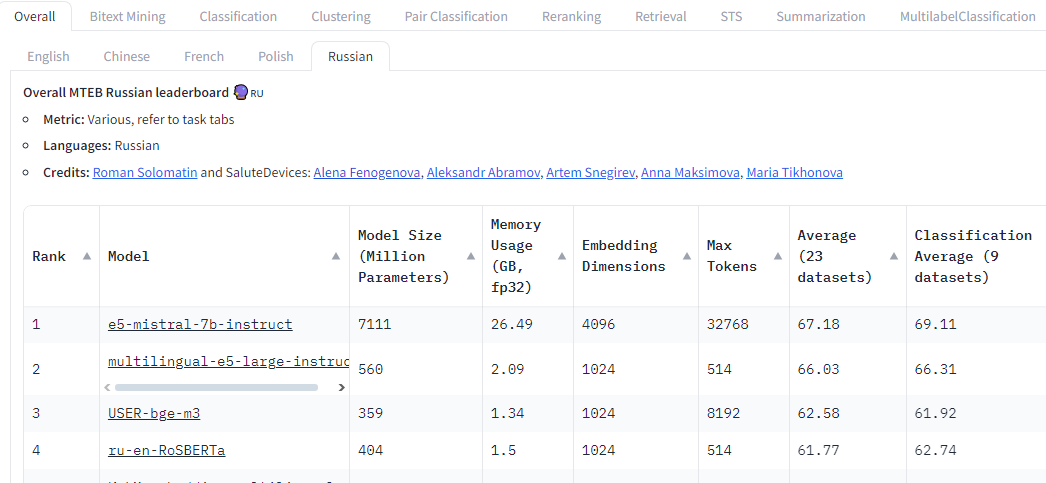

Согласно лидерборду моделей для векторизации текстов на русском языке, multilingual-e5-large-instruct является второй по качеству, однако первая по кчеству модель в 13 раз больше по размеру в сравнении с multilingual-e5-large-instruct, что может негативно сказаться на скорости при ее использовании.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')

texts = df_train['Тема_Описание'].tolist()

batch_dict = tokenizer(texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs = model(**batch_dict)

def average_pool(last_hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    ''' 
    Функция average_pool выполняет усреднение скрытых состояний последнего слоя модели, 
    учитывая маску внимания. 

    Параметры:
    - last_hidden_states: Тензор, содержащий скрытые состояния последнего слоя модели. 
      Размерность тензора - (batch_size, sequence_length, hidden_size).
    - attention_mask: Тензор, указывающий, какие токены следует учитывать при усреднении. 
      Размерность тензора - (batch_size, sequence_length).

    Возвращает:
    - Тензор, представляющий усредненные эмбеддинги для каждого примера в батче. 
      Размерность тензора - (batch_size, hidden_size).
    
    Процесс:
    1. Скрытые состояния, соответствующие токенам, которые не должны учитываться (например, паддинг), 
       заменяются на нули с помощью метода masked_fill.
    2. Затем выполняется суммирование скрытых состояний по временной оси (dim=1).
    3. Наконец, результат делится на количество токенов, которые были учтены (сумма маски внимания), 
       чтобы получить усредненные эмбеддинги.
    '''
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

embeddings = F.normalize(embeddings, p=2, dim=1)

In [17]:
embeddings_df = pd.DataFrame(embeddings.numpy(), columns=[f'embedding_{i}' for i in range(embeddings.shape[1])])

df_train = pd.concat([df_train.drop(columns=['Тема_Описание']), embeddings_df], axis=1)

df_train

,Тип оборудования,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1014,embedding_1015,embedding_1016,embedding_1017,embedding_1018,embedding_1019,embedding_1020,embedding_1021,embedding_1022,embedding_1023
0,Ноутбук,0.021880,0.000266,-0.016779,-0.032101,0.041302,-0.003823,-0.027679,0.128333,0.044932,...,-0.014802,-0.049298,-0.013734,-0.022491,0.007650,0.028164,0.025039,-0.026492,-0.050613,0.022895
1,Ноутбук,0.000710,0.018861,-0.022094,-0.043200,0.027966,-0.013464,-0.032622,0.095621,0.018601,...,-0.014303,-0.052902,-0.008643,-0.017012,0.002425,0.043361,0.036186,-0.035695,-0.020255,0.008480
2,Ноутбук,0.014018,0.016968,-0.022333,-0.050782,0.013659,-0.009213,-0.027521,0.100397,0.013647,...,-0.007453,-0.035183,0.000590,-0.022955,0.004155,0.060856,0.031812,-0.021440,-0.045939,0.000906
3,Ноутбук,0.002344,0.024181,-0.015709,-0.054320,0.018772,0.017711,-0.035852,0.084475,0.019610,...,-0.009498,-0.056558,-0.001000,-0.021705,0.012198,0.043378,0.010904,-0.014733,-0.038842,0.019998
4,Сервер,0.011309,-0.000647,-0.044379,-0.037740,0.007516,-0.015195,-0.037206,0.093387,0.043190,...,-0.008127,-0.032145,0.001245,-0.001029,-0.005868,0.023222,0.024029,-0.018698,0.000710,-0.002080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,СХД,0.029031,0.010029,-0.017460,-0.030513,0.024274,-0.005606,-0.007858,0.109613,0.042421,...,-0.021586,-0.022955,0.001541,0.030305,0.019886,0.047997,0.033686,-0.015879,-0.041352,0.015383
765,Ноутбук,0.035530,0.010284,-0.016200,-0.041343,0.037488,0.006717,-0.019410,0.085637,0.023744,...,-0.018881,-0.038320,0.004177,-0.030076,0.012723,0.048086,0.017010,-0.033665,-0.026992,-0.001788
766,Сервер,-0.003732,0.015698,-0.013889,-0.047607,0.025449,-0.024654,-0.018967,0.068062,0.057799,...,-0.013290,-0.049349,0.004042,-0.000056,0.003503,0.027661,0.021733,-0.017478,-0.034636,0.033220
767,СХД,0.011897,-0.009697,-0.022931,-0.027860,0.017716,0.008884,-0.036745,0.087186,0.049200,...,-0.028512,-0.043076,-0.002186,-0.023385,0.014416,0.036072,0.017025,-0.021955,-0.049078,-0.006850


Сохраним полученный датасет с эмбедингами

In [ ]:
df_train.to_csv('../data/df_train_balanced_by_equipmen_embeded.csv', index=False)

In [ ]:
# df_train = pd.read_csv('df_train_balanced_by_equipmen_embeded.csv')

In [19]:
df_test['Тема_Описание'] = df_test['Тема'] + ' ' + df_test['Описание']

df_test = df_test.drop(columns=['Точка отказа', 'Серийный номер', 'Тема', 'Описание'])

texts_test = df_test['Тема_Описание'].tolist()
batch_dict_test = tokenizer(texts_test, max_length=512, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs_test = model(**batch_dict_test)

embeddings_test = average_pool(outputs_test.last_hidden_state, batch_dict_test['attention_mask'])

embeddings_test = F.normalize(embeddings_test, p=2, dim=1)

embeddings_df_test = pd.DataFrame(embeddings_test.numpy(), columns=[f'embedding_{i}' for i in range(embeddings_test.shape[1])])

df_test = pd.concat([df_test.drop(columns=['Тема_Описание']), embeddings_df_test], axis=1)

df_test

,Тип оборудования,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1014,embedding_1015,embedding_1016,embedding_1017,embedding_1018,embedding_1019,embedding_1020,embedding_1021,embedding_1022,embedding_1023
0,Ноутбук,0.004923,0.000164,-0.025579,-0.043392,0.043631,-0.016459,-0.035255,0.090263,0.047798,...,-0.008347,-0.043617,-0.001692,-0.010358,-0.000779,0.036359,0.012551,-0.010571,-0.047335,0.037225
1,Ноутбук,0.016324,0.013715,-0.021093,-0.030459,0.017148,0.007304,-0.023628,0.103826,0.032410,...,-0.013449,-0.035001,-0.007832,-0.042813,0.012528,0.049815,0.005873,-0.025110,-0.045805,0.041621
2,Ноутбук,0.011085,0.014219,-0.019757,-0.038170,0.024651,0.005413,-0.016987,0.094807,0.036698,...,-0.005538,-0.042123,-0.029577,-0.010607,0.010141,0.027002,0.012893,-0.034279,-0.024013,0.035265
3,Ноутбук,0.007823,0.000733,-0.026442,-0.047472,0.034917,0.006790,-0.027565,0.120560,0.026114,...,-0.017341,-0.047157,-0.009806,-0.019740,0.019341,0.016324,0.024278,-0.024008,-0.041520,0.035229
4,Ноутбук,0.013135,0.012190,-0.027954,-0.037627,0.040154,-0.014455,-0.013765,0.085040,0.042235,...,-0.012664,-0.051445,-0.015321,-0.011579,-0.002245,0.033686,0.041446,-0.024646,-0.043730,0.027199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Ноутбук,0.007131,0.019693,-0.014051,-0.055724,0.026193,-0.001735,-0.020590,0.134525,0.030687,...,-0.005715,-0.035706,-0.024780,-0.011823,0.004478,0.024706,0.025833,-0.025649,-0.042067,0.021933
61,СХД,0.010910,0.016301,-0.004598,-0.037258,0.033857,-0.015950,-0.043913,0.111341,0.053975,...,0.005677,-0.024711,-0.012773,-0.002875,-0.004472,0.041322,0.046584,-0.016264,-0.051200,0.008428
62,Ноутбук,0.006911,0.011776,-0.031072,-0.049886,0.035273,0.005213,-0.023576,0.080160,0.024793,...,-0.010701,-0.024650,0.015551,-0.008627,-0.011222,0.039922,0.039776,-0.042860,-0.020780,0.008196
63,Ноутбук,0.019854,0.012499,-0.022903,-0.047889,0.029688,-0.027159,-0.019775,0.100249,0.044963,...,-0.013594,-0.029137,0.000528,-0.023010,-0.007126,0.032082,0.035596,-0.030567,-0.053776,0.017362


Сохраним датасет с полученными эмбедингами.

In [24]:
df_test.to_csv('../data/df_test_balanced_by_equipmen_embeded.csv', index=False)

Выбор модели CatBoost Classifier для трехклассовой классификации текстов обоснован несколькими важными факторами. Во-первых, CatBoost — это алгоритм градиентного бустинга, который демонстрирует высокую эффективность и точность при работе с категориальными данными, что особенно актуально для текстов, где слова и фразы могут быть представлены как категориальные признаки. Во-вторых, CatBoost автоматически обрабатывает категориальные переменные, что упрощает предобработку данных и снижает вероятность ошибок, связанных с ручным кодированием.
Кроме того, CatBoost обладает встроенной поддержкой многоклассовой классификации, что делает его идеальным выбором для задач, где необходимо различать более чем два класса. Модель также устойчива к переобучению и может эффективно работать с небольшими объемами данных, что часто встречается в задачах классификации текстов. Наконец, CatBoost обеспечивает высокую скорость обучения и предсказания, что позволяет быстро получать результаты и проводить итерации в процессе разработки модели.

In [ ]:
X = df_train.drop(columns=['Тип оборудования'])
y = df_train['Тип оборудования']

In [ ]:
X_test = df_test.drop(columns=['Тип оборудования'])
y_test = df_test['Тип оборудования']

Подберем оптимальные параметры для модели.

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV


cb_model = CatBoostClassifier(verbose=0)

param_grid = {
    'iterations': [500, 1000, 2000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 1, 2]
}

grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [ ]:
from catboost import CatBoostClassifier

cb_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=100)

cb_model.fit(X, y)

0:	learn: 0.9726938	total: 171ms	remaining: 2m 50s
100:	learn: 0.0217702	total: 15.1s	remaining: 2m 14s
200:	learn: 0.0075687	total: 29.4s	remaining: 1m 56s
300:	learn: 0.0046552	total: 43.3s	remaining: 1m 40s
400:	learn: 0.0033840	total: 56.9s	remaining: 1m 24s
500:	learn: 0.0025511	total: 1m 10s	remaining: 1m 10s
600:	learn: 0.0020891	total: 1m 24s	remaining: 55.8s
700:	learn: 0.0017600	total: 1m 38s	remaining: 42s
800:	learn: 0.0015212	total: 1m 52s	remaining: 27.9s
900:	learn: 0.0013270	total: 2m 6s	remaining: 13.9s
999:	learn: 0.0011918	total: 2m 19s	remaining: 0us


Оценим качество обученной модели метриками.

In [21]:
y_pred = cb_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Ноутбук       0.98      1.00      0.99        48
         СХД       1.00      1.00      1.00         7
      Сервер       1.00      0.90      0.95        10

    accuracy                           0.98        65
   macro avg       0.99      0.97      0.98        65
weighted avg       0.98      0.98      0.98        65



Сохраним обученную модель в формате .pkl.

In [23]:
from joblib import dump

dump(cb_model, '../models/cb_equipment_model.pkl')

['../models/cb_equipment_model.pkl']

# Обучение модели на всех данных

Теперь прогони м весь путь обучения модели на всех данных.

In [29]:
df_test = pd.read_csv(save_path_test)

In [ ]:
df_test = df_test.drop(columns=['Точка отказа', 'Серийный номер', 'Тема', 'Описание'])

In [47]:
df_train = pd.read_csv('../data/data_balanced_by_equipment.csv')
df = pd.read_csv('../data/df_train_balanced_by_equipment.csv')

df_train = pd.concat([df_train, df], ignore_index=True)
df_train

,Тема,Описание,Тип оборудования,Точка отказа,Серийный номер
0,+BB0EPgRDBEIEMQRDBDo- +BCEEGAQbBBA- +BB0EGg-2-...,Здравствуйте.\n\n Сломался блок...,Ноутбук,Блок питания,C222090381
1,/ шумит кулер / отклеились ножки,"Коллеги, добрый день.\n\nПрошу осуществить заб...",Ноутбук,Вентилятор,C223010310
2,10552. СИЛА HK-1404 // замена блоков питания //,"Добрый день! Не работают блоки питания, прошу ...",Ноутбук,Блок питания,"C223010423, C223011174"
3,10979. Ноутбук СИЛА НК2-1404 // не включается,Добрый день! Ноутбук не включается,Ноутбук,Материнская плата,C223012335
4,BIOS'ы,"Здравствуйте!\nПоделитесь, пожалуйста, последн...",Ноутбук,Консультация,C223010345
...,...,...,...,...,...
1259,Проблемы с СХД,"Некоторые диски вышли из строя, и резервная ко...",СХД,Диск,CKM01212505744
1260,Не работают звук и микрофон на ноутбуке,Не функционируют звук и микрофон на ноутбуке.,Ноутбук,Материнская плата,c223012961
1261,Неисправность сервера,"Добрый день, коллеги. Прошу принять запрос о н...",Сервер,Сервер,D252030012
1262,Открыть кейс по неисправности диска,Добрый день. Прошу открыть кейс по неисправном...,СХД,Диск,CKM00194401300


In [48]:
df_train = df_train.drop_duplicates()

df_train = df_train.reset_index(drop=True)

df_train

,Тема,Описание,Тип оборудования,Точка отказа,Серийный номер
0,+BB0EPgRDBEIEMQRDBDo- +BCEEGAQbBBA- +BB0EGg-2-...,Здравствуйте.\n\n Сломался блок...,Ноутбук,Блок питания,C222090381
1,/ шумит кулер / отклеились ножки,"Коллеги, добрый день.\n\nПрошу осуществить заб...",Ноутбук,Вентилятор,C223010310
2,10552. СИЛА HK-1404 // замена блоков питания //,"Добрый день! Не работают блоки питания, прошу ...",Ноутбук,Блок питания,"C223010423, C223011174"
3,10979. Ноутбук СИЛА НК2-1404 // не включается,Добрый день! Ноутбук не включается,Ноутбук,Материнская плата,C223012335
4,BIOS'ы,"Здравствуйте!\nПоделитесь, пожалуйста, последн...",Ноутбук,Консультация,C223010345
...,...,...,...,...,...
861,Проблемы со звуком и микрофоном,Не функционируют звук и микрофон на ноутбуке.,Ноутбук,Материнская плата,c223012961
862,Ноутбук не включается,"Ноутбук не подает признаков жизни, индикаторы ...",Ноутбук,Материнская плата,C223010076
863,СР2-5422,Обнаружены неполадки в функционировании сервер...,Сервер,Материнская плата,D251110010
864,Ноутбук,У ноутбука СИЛА НК2-1404 с серийным номером C2...,Ноутбук,Диск,C222091115


In [49]:
df_train['Тема_Описание'] = df_train['Тема'] + ' ' + df_train['Описание']

df_train = df_train.drop(columns=['Точка отказа', 'Серийный номер', 'Тема', 'Описание'])

df_train

,Тип оборудования,Тема_Описание
0,Ноутбук,+BB0EPgRDBEIEMQRDBDo- +BCEEGAQbBBA- +BB0EGg-2-...
1,Ноутбук,"/ шумит кулер / отклеились ножки Коллеги, добр..."
2,Ноутбук,10552. СИЛА HK-1404 // замена блоков питания /...
3,Ноутбук,10979. Ноутбук СИЛА НК2-1404 // не включается ...
4,Ноутбук,"BIOS'ы Здравствуйте!\nПоделитесь, пожалуйста, ..."
...,...,...
861,Ноутбук,Проблемы со звуком и микрофоном Не функциониру...
862,Ноутбук,Ноутбук не включается Ноутбук не подает призна...
863,Сервер,СР2-5422 Обнаружены неполадки в функционирован...
864,Ноутбук,Ноутбук У ноутбука СИЛА НК2-1404 с серийным но...


In [50]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')

texts = df_train['Тема_Описание'].tolist()

batch_dict = tokenizer(texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs = model(**batch_dict)

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

embeddings = F.normalize(embeddings, p=2, dim=1)

In [51]:
embeddings_df = pd.DataFrame(embeddings.numpy(), columns=[f'embedding_{i}' for i in range(embeddings.shape[1])])

df_train = pd.concat([df_train.drop(columns=['Тема_Описание']), embeddings_df], axis=1)

df_train

,Тип оборудования,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1014,embedding_1015,embedding_1016,embedding_1017,embedding_1018,embedding_1019,embedding_1020,embedding_1021,embedding_1022,embedding_1023
0,Ноутбук,0.023536,0.023417,-0.031006,-0.037854,0.030465,-0.024322,-0.012835,0.109639,0.037406,...,-0.013566,-0.030093,0.002128,-0.017783,0.010681,0.049917,0.031316,-0.008104,-0.052189,0.018549
1,Ноутбук,0.030353,0.003065,-0.024998,-0.018532,0.025321,-0.012669,-0.029280,0.093894,0.017282,...,-0.008042,-0.045622,-0.017020,-0.006478,0.003175,0.013241,0.045212,-0.030071,-0.007685,0.006248
2,Ноутбук,0.022964,0.028423,-0.024349,-0.046956,0.026882,-0.033127,-0.017273,0.077270,0.055110,...,-0.000764,-0.028447,0.009265,-0.009530,0.002511,0.033808,0.061902,-0.031258,-0.048267,0.028450
3,Ноутбук,0.010319,0.006818,-0.019722,-0.053926,0.022002,-0.002210,-0.014835,0.081232,0.039699,...,-0.007469,-0.024292,-0.008178,-0.015585,0.005126,0.041172,0.010788,-0.029507,-0.044128,0.011589
4,Ноутбук,0.023764,0.003196,-0.028950,-0.040245,0.007245,-0.015772,-0.008774,0.074797,0.043357,...,-0.011282,-0.056233,0.025438,-0.010304,0.022310,0.054039,-0.002527,-0.032880,-0.030656,-0.001451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,Ноутбук,0.037352,0.007124,-0.019469,-0.041316,0.033624,0.011833,-0.022123,0.085401,0.030303,...,-0.017612,-0.046417,0.011165,-0.024834,0.008917,0.047353,0.028860,-0.031464,-0.028254,-0.004409
862,Ноутбук,0.015370,-0.000909,-0.014503,-0.038597,0.017059,-0.004342,-0.016412,0.092020,0.041758,...,-0.015728,-0.022406,-0.020102,-0.020131,0.015740,0.026167,0.004474,-0.035701,-0.023982,0.006044
863,Сервер,0.002847,0.032606,-0.010805,-0.055344,0.024620,-0.008807,-0.035608,0.100356,0.034167,...,-0.006885,-0.031978,-0.010178,-0.002958,-0.012171,0.045692,0.033124,-0.016378,-0.037373,0.014302
864,Ноутбук,0.005263,-0.000393,-0.012121,-0.036828,0.031061,0.018386,-0.033470,0.109728,0.036127,...,-0.025054,-0.036288,0.001554,-0.011945,-0.002494,0.041852,0.022912,-0.021060,-0.053441,0.028661


In [52]:
from catboost import CatBoostClassifier

X = df_train.drop(columns=['Тип оборудования'])
y = df_train['Тип оборудования']

cb_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=100)

cb_model.fit(X, y)

0:	learn: 1.0021741	total: 264ms	remaining: 4m 23s
100:	learn: 0.0275231	total: 19.4s	remaining: 2m 52s
200:	learn: 0.0092325	total: 39.7s	remaining: 2m 37s
300:	learn: 0.0054655	total: 59.9s	remaining: 2m 19s
400:	learn: 0.0038227	total: 1m 19s	remaining: 1m 59s
500:	learn: 0.0029194	total: 1m 40s	remaining: 1m 40s
600:	learn: 0.0023523	total: 2m	remaining: 1m 19s
700:	learn: 0.0019456	total: 2m 20s	remaining: 1m
800:	learn: 0.0016662	total: 2m 41s	remaining: 40.2s
900:	learn: 0.0014423	total: 3m 1s	remaining: 19.9s
999:	learn: 0.0012679	total: 3m 21s	remaining: 0us


In [53]:
from joblib import dump

dump(cb_model, '../models/cb_equipment_model.pkl')

['../models/cb_equipment_model.pkl']

# Получение прогнозов

In [54]:
from joblib import load

cb_model = load('../models/cb_equipment_model.pkl')

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')


def average_pool(last_hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    ''' 
    Функция average_pool выполняет усреднение скрытых состояний последнего слоя модели, 
    учитывая маску внимания. 

    Параметры:
    - last_hidden_states: Тензор, содержащий скрытые состояния последнего слоя модели. 
      Размерность тензора - (batch_size, sequence_length, hidden_size).
    - attention_mask: Тензор, указывающий, какие токены следует учитывать при усреднении. 
      Размерность тензора - (batch_size, sequence_length).

    Возвращает:
    - Тензор, представляющий усредненные эмбеддинги для каждого примера в батче. 
      Размерность тензора - (batch_size, hidden_size).
    
    Процесс:
    1. Скрытые состояния, соответствующие токенам, которые не должны учитываться (например, паддинг), 
       заменяются на нули с помощью метода masked_fill.
    2. Затем выполняется суммирование скрытых состояний по временной оси (dim=1).
    3. Наконец, результат делится на количество токенов, которые были учтены (сумма маски внимания), 
       чтобы получить усредненные эмбеддинги.
    '''
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [64]:
def create_embeddings(topic: str, description: str, model, tokenizer) -> torch.Tensor:
    '''
    Функция для создания эмбеддингов (векторных представлений) текста на основе заданной темы и описания.

    Параметры:
    - topic (str): Тема, для которой необходимо создать эмбеддинг.
    - description (str): Описание, связанное с темой.
    - model: Предобученная модель, используемая для генерации эмбеддингов.
    - tokenizer: Токенизатор, который преобразует текст в формат, подходящий для модели.

    Описание работы функции:
    1. Функция объединяет тему и описание в одну строку `text_input`.
    2. Затем текст токенизируется с помощью переданного токенизатора, при этом устанавливаются максимальная длина (512 токенов), а также параметры для дополнения и обрезки, чтобы получить тензоры, совместимые с моделью.
    3. В блоке `with torch.no_grad()` отключается отслеживание градиентов, что позволяет экономить память и ускорять вычисления во время инференса.
    4. Модель обрабатывает токенизированный ввод, и из выходных данных извлекается `last_hidden_state`, который содержит представления всех токенов.
    5. Эмбеддинги усредняются с использованием функции `average_pool`, учитывающей маску внимания, чтобы получить одно векторное представление для всего текста.
    6. Полученные эмбеддинги нормализуются с использованием L2-нормализации, что позволяет улучшить их качество и делает их более пригодными для последующих задач, таких как сравнение или кластеризация.

    Возвращает:
    - torch.Tensor: Нормализованный тензор эмбеддингов, представляющий объединенное текстовое представление темы и описания.
    '''
    
    text_input = f"{topic} {description}"

    batch_dict = tokenizer([text_input], max_length=512, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        outputs = model(**batch_dict)

    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

    return embeddings

In [65]:
def generate_prediction(topic: str, description: str, model, tokenizer, cb_model) -> str:
    ''' 
    Функция generate_prediction генерирует предсказание темы обращения для заданного текста, 
    состоящего из темы и описания, используя предобученную модель и токенизатор.

    Параметры:
    - topic: Строка, представляющая тему текста, для которого необходимо сделать предсказание.
    - description: Строка, представляющая описание текста, для которого необходимо сделать предсказание.
    - model: Предобученная модель, используемая для получения эмбеддингов текста.
    - tokenizer: Токенизатор, используемый для преобразования текста в формат, 
      подходящий для модели.
    - cb_model: Модель, используемая для генерации предсказаний на основе эмбеддингов.

    Возвращает:
    - str: Предсказанный тип обращения для заданного текста.

    Процесс:
    1. Формируется текстовый ввод, объединяя тему и описание.
    2. Текст токенизируется и преобразуется в тензоры, подходящие для модели, с учетом 
       максимальной длины, паддинга и обрезки.
    3. С помощью модели получаются скрытые состояния, при этом отключается градиент 
       для экономии памяти и ускорения вычислений.
    4. Вызывается функция average_pool для получения усредненных эмбеддингов на основе 
       скрытых состояний и маски внимания.
    5. Эмбеддинги нормализуются для улучшения качества предсказаний.
    6. На основе нормализованных эмбеддингов генерируется предсказание с помощью cb_model.
    7. Возвращается предсказанный класс.
    '''

    embeddings = create_embeddings(topic, description, model, tokenizer)

    prediction = cb_model.predict(embeddings.numpy())

    return str(prediction[0][0])

topic = "Замена клавиатуры"
description = "согласована замена клавиатуры на ноутбуке  C223010701 в рамках гарантийных обязательств , с выездом инженера на локацию"
predicted_class = generate_prediction(topic, description, model, tokenizer, cb_model)
print(predicted_class)

Ноутбук


In [68]:
def generate_predictions_from_dataframe(df: pd.DataFrame, model, tokenizer, cb_model) -> pd.Series:
    ''' 
    Функция generate_predictions_from_dataframe генерирует предсказания для каждого 
    текста в DataFrame, используя предобученную модель и токенизатор.

    Параметры:
    - df: DataFrame, содержащий данные с текстами, для которых необходимо сделать предсказания. 
      Ожидается, что в DataFrame есть столбцы 'Тема' и 'Описание'.
    - model: Предобученная модель, используемая для получения эмбеддингов текста.
    - tokenizer: Токенизатор, используемый для преобразования текстов в формат, 
      подходящий для модели.
    - cb_model: Модель, используемая для генерации предсказаний на основе эмбеддингов.

    Возвращает:
    - pd.Series: Серия с предсказанными классами для каждого текста в DataFrame.

    Процесс:
    1. Инициализируется пустой список для хранения предсказаний.
    2. Для каждой строки в DataFrame:
       - Формируется текстовый ввод, объединяя 'Тема' и 'Описание'.
       - Текст токенизируется и преобразуется в тензоры, подходящие для модели.
       - С помощью модели получаются скрытые состояния.
       - Вызывается функция average_pool для получения усредненных эмбеддингов.
       - Эмбеддинги нормализуются.
       - На основе нормализованных эмбеддингов генерируется предсказание с помощью cb_model.
       - Предсказание добавляется в список.
    3. Возвращается серия с предсказанными классами.
    '''
    predictions = []

    for index, row in df.iterrows():
        embeddings = create_embeddings(row['Тема'], row['Описание'], model, tokenizer)

        prediction = cb_model.predict(embeddings.numpy())
        predictions.append(prediction[0][0])

    return pd.Series(predictions)

predicted_classes = generate_predictions_from_dataframe(df_test, model, tokenizer, cb_model)
predicted_classes

0     Ноутбук
1     Ноутбук
2     Ноутбук
3     Ноутбук
4     Ноутбук
       ...   
60    Ноутбук
61        СХД
62    Ноутбук
63    Ноутбук
64    Ноутбук
Length: 65, dtype: object